In [1]:
import numpy as np
import visa
import matplotlib.pyplot as plt
import time
from lantz import MessageBasedDriver, Q_
from lantz.core import Feat
from lantz.core import mfeats
from lantz import ureg
import sounddevice as sd
from scipy import signal as sg

In [2]:
class Generador(MessageBasedDriver):
#    def __init__(self,ID):
#        self.obj_visa=rm.open_resource(ID)
#        self.ID = ID
    set_query = MessageBasedDriver.write
    # Feats punciona como un property, pero ademas acepta otras opciones
    @Feat()
    def idn(self):
        return self.query('*IDN?')

    # La idea es no usar sets and gets como metodos, sino definir propiedades
        
    frequency = mfeats.QuantityFeat('SOURce1:FREQuency:FIXed?','SOURce1:FREQuency:FIXed {}',units='Hz',limits=(0.0,1000000))
    amplitude = mfeats.QuantityFeat('SOURce1:VOLT:LEV:IMM:AMPL?','SOURce1:VOLT:LEV:IMM:AMPL {}',units='V',limits=(0.05,5))
    offset = mfeats.QuantityFeat('SOURce1:VOLT:LEV:IMM:OFFS?','SOURce1:VOLT:LEV:IMM:OFFS {}',units='V',limits=(0,10))
        
    def setWaveform(self,waveform ='Senoidal'):
        switcher = {'Senoidal':"SIN",'Cuadrada':"SQU",'Pulso':"PULS"}
        self.write("SOURce1:FUNCtion "+switcher.get(waveform,'Senoidal'))  

        
class Osciloscopio(MessageBasedDriver):

    set_query = MessageBasedDriver.write
    
    @Feat()
    def idn(self):
        return self.query('*IDN?')

    timebase = mfeats.QuantityFeat('HORizontal:MAIN:SCALe?','HORizontal:MAIN:SCALe {}',units='s')
    vertical_scale = mfeats.QuantityFeat('CH1:SCA?','CH1:SCA {}',units='V')

    def vpp(self):
        osci.write('MEASUrement:IMMed:TYPE PK2pk')
        return float(osci.query('MEASUREMENT:IMMed:VALue?'))

    def mean(self):
        osci.write('MEASUrement:IMMed:TYPE MEAN')
        return float(osci.query('MEASUREMENT:IMMed:VALue?')) 
    
    @Feat()
    def capturaPantalla(self):
 #       if self.parameters is None:
        YOFF_in_dl = float(self.query("WFMP:YOFF?"))
        YZERO_in_YUNits = float(self.query("WFMP:YZERO?"))
        YMUlt = float(self.query("WFMP:YMULT?"))
        print(YOFF_in_dl,YZERO_in_YUNits,YMUlt)
     #   self.parameters = (YOFF_in_dl,YZERO_in_YUNits,YMUlt)
      #  (YOFF_in_dl , YZERO_in_YUNits , YMUlt) = self.parameters
        curve_in_dl = np.array(self.query('CURV?'))#, datatype='b', is_big_endian=True))
        valores = ((curve_in_dl - YOFF_in_dl)*YMUlt)+YZERO_in_YUNits
        intervalo = float(osci.query('WFMPre:XINcr?'))
        tiempos = np.arange(len(valores))*intervalo
        return tiempos, valores
    

In [3]:
def sweepe_placa(gener, init_freq = 100, end_freq = 1100, cant_med = 100,prom_number=1):
    with gener as generador:
        paso = np.floor(np.divide(end_freq - init_freq,cant_med))
        amplitud = np.zeros(cant_med)
        offset = np.zeros(cant_med)
        freqs = np.add(np.multiply(np.arange(cant_med), paso), init_freq)
        for i,freq in enumerate(freqs):
            periodo = np.divide(1,freq)
            generador.frequency= freq*ureg.hertz
        # Esperamos a que se setee y lea bien
            time.sleep(1)
            numero_de_muestras = int(2* periodo * sd.default.samplerate)
            amplitud_prom = 0
            offset_prom = 0
            for n in range(prom_number):
            # Consulta Placa
                myrecording = sd.rec(numero_de_muestras,channels=2,blocking=True)
                medicion = np.asarray([i[0] for i in myrecording])
                maximo = np.max(medicion)
                minimo = np.min(medicion)
                amplitud_prom = amplitud_prom + maximo - minimo
                offset_prom = offset_prom + np.divide(maximo + minimo,2)
            amplitud[i] = np.divide(amplitud_prom,prom_number)
            offset[i] = np.divide(offset_prom,prom_number)
        return freqs, amplitud, offset

In [128]:
rm = visa.ResourceManager()
ID=rm.list_resources()
genf = Generador(ID[0])
osci = Osciloscopio(ID[1])

In [5]:
ID

('USB0::0x0699::0x0346::C034165::INSTR',
 'USB0::0x0699::0x0363::C108011::INSTR')

In [6]:
sd.default.samplerate = 44100 

La nueva función senoidal que definimos a continuación incorpora la posibilidad de tener un offset de tensión para alimentar con señales DC

In [126]:
def Senoidal(Offs,Ampl,Freq,nPeriods):
    n=nPeriods
    SR = sd.default.samplerate
    t = np.linspace(0,n*np.divide(1,Freq),n*int(np.divide(SR,Freq)),endpoint=False) # valores de tiempo que van a ser barridos.
    return t,np.divide(Ampl*np.sin(2*np.pi*Freq*t)+Offs,1.6)

def PlaySin(Ampl,Freq,Time):
    t,y=Senoidal(Ampl,Freq,1)
    sd.play(y,loop=True)
    time.sleep(Time)
    sd.stop()

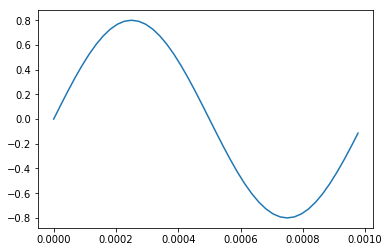

In [96]:
Freq = 1000
t,y=Senoidal(0,.5,Freq,1)
plt.plot(t,y,'-')

sd.play(y,loop=True)

In [41]:
V_in=np.linspace(0,0.5,60)
V_out = []
with osci as osciloscopio:
    for i in V_in:
        t,y=Senoidal(0,i,1000,1)
        sd.play(y,loop=True)
        time.sleep(2)
        V_out.append(osciloscopio.vpp())
        sd.stop()
        
plt.plot(V_in,np.divide(V_out,2),'.-')

sd.stop()

KeyboardInterrupt: 

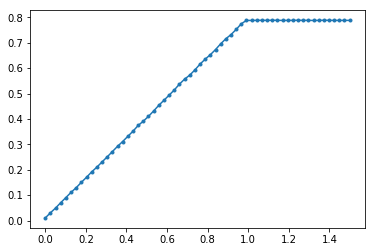

In [35]:
V_in=np.linspace(0,1.5,60)
V_out = []
with osci as osciloscopio:
    for i in V_in:
        t,y=Senoidal(i,0,1000,1)
        sd.play(y,loop=True)
        time.sleep(2)
        V_out.append(osciloscopio.mean())
        sd.stop()
        
plt.plot(V_in,np.divide(V_out,2),'.-')

sd.stop()

In [8]:
sd.query_devices()

  0 Asignador de sonido Microsoft - Input, MME (2 in, 0 out)
> 1 Micrófono (Dispositivo de High , MME (2 in, 0 out)
  2 Asignador de sonido Microsoft - Output, MME (0 in, 2 out)
< 3 Auriculares (Dispositivo de Hig, MME (0 in, 2 out)
  4 Altavoces (Dispositivo de High , MME (0 in, 2 out)
  5 Headphones (Auricular de HD Audio), Windows WDM-KS (0 in, 2 out)
  6 Micrófono (Micrófono 2 de HD Audio), Windows WDM-KS (2 in, 0 out)
  7 Micrófono (Micrófono de HD Audio), Windows WDM-KS (2 in, 0 out)
  8 Speakers (Altavoz de HD Audio), Windows WDM-KS (0 in, 2 out)

(0, 0.002)

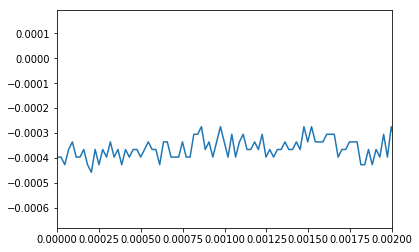

In [70]:
N=10000
i=3
with osci as osciloscopio, genf as generador:
    generador.amplitude = i*ureg.volts
time.sleep(2)        
myrecording = sd.rec(N,channels=2,blocking=True)
ch1=np.asarray([i[0] for i in myrecording])
ch2=np.asarray([i[1] for i in myrecording])
tiempo = np.divide(np.arange(len(ch1)),sd.default.samplerate)
plt.plot(tiempo,ch1)
#plt.plot(tiempo,ch2+0.5)
#plt.plot(medicion)
plt.xlim(0,0.002)

In [15]:
np.arange(5)

array([0, 1, 2, 3, 4])

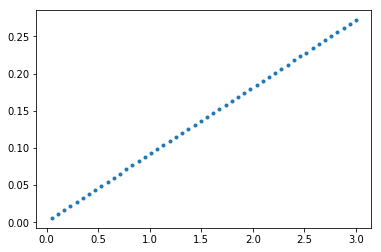

In [47]:
V_in = np.linspace(0.05,3,50)
N=10000
V_pl = []
with osci as osciloscopio, genf as generador:
    for i in V_in:
        generador.amplitude = i*ureg.volts
        generador.offset = 0*ureg.volts
        time.sleep(2)
        myrecording = sd.rec(N,channels=2,blocking=True)
        ch1=np.asarray([i[0] for i in myrecording])
        v=np.max(ch1)-np.min(ch1)
        #i_d.append(np.divide(v,1000))
        V_pl.append(v)
plt.plot(V_in,V_pl,'.')

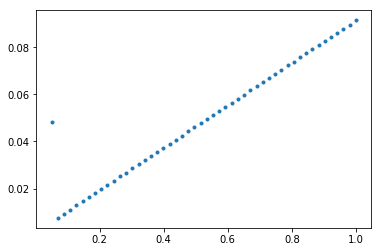

In [32]:
plt.plot(V_in,np.multiply(V_pl,2),'.')

In [49]:
np.savetxt('C:/Users/usuario/Documents/GitHub/Instrumentacion_y_control/Informe_1/Datos/Caracterizacion_Vin_placa_1kHz.txt',(V_in,V_pl))

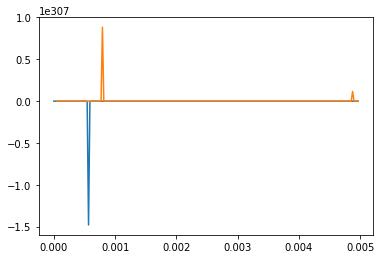

In [120]:
Freq = 1000
t,y=Senoidal(0,.5,Freq,1)
sonido = np.concatenate((y,y,y,y,y))
#sd.play(y,loop=True)
myrecording = sd.playrec(sonido, channels=2)

ch1=np.asarray([i[0] for i in myrecording])
ch2=np.asarray([i[1] for i in myrecording])
tiempo = np.divide(np.arange(len(ch1)),sd.default.samplerate)
plt.plot(tiempo,ch1)
plt.plot(tiempo,ch2)
#plt.plot(medicion)
#plt.xlim(0,.01)

In [123]:
sd.stop()

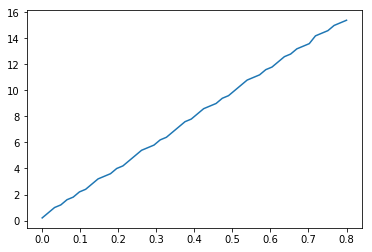

In [129]:
V_in = np.linspace(0,0.8,50)
V_osci = []
Freq = 1000
with osci as osciloscopio, genf as generador:
    for i in V_in:      
        t,y=Senoidal(0,i,Freq,1)
        sd.play(y,loop=True)
        time.sleep(2)
        V_osci.append(osciloscopio.vpp())
plt.plot(V_in,V_osci)

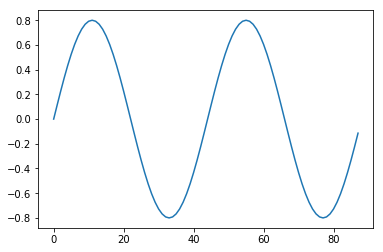

In [114]:
plt.plot(sonido)

In [130]:
np.savetxt('C:/Users/usuario/Documents/GitHub/Instrumentacion_y_control/Informe_1/Datos/Ganancia_opam_10.txt',(V_in,V_osci))